In [55]:
import numpy as np
import pandas as pd
import librosa
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.ensemble import VotingClassifier

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import gc

In [3]:
# Load the annotations file
anno = pd.read_csv('data/annotations.csv')

In [5]:
# Function to extract MFCCs from an audio file
def extract_mfccs(file_path, n_mfcc=13):
    y, sr = librosa.load(file_path, sr=None)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    return np.mean(mfccs, axis=1)

In [7]:
# Extract features and labels
features = np.array([extract_mfccs(f'data/audio/{row["filename"]}') for index, row in anno.iterrows()])
labels = anno['context'].values

In [9]:
# Standardize features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Encode labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

In [11]:
# Define models and hyperparameters
models = {
    'Random Forest': RandomForestClassifier(),
    'Support Vector Machine': SVC(probability=True),  # enable probability estimates for ROC curve
    'MLP': MLPClassifier(hidden_layer_sizes=(50,), max_iter=200, activation='relu', solver='adam', early_stopping=True)  # simpler network with early stopping
}

param_grids = {
    'Random Forest': {
        'model__n_estimators': [50, 100],
        'model__max_depth': [None, 10, 20]
    },
    'Support Vector Machine': {
        'model__C': [0.1, 1, 10],
        'model__kernel': ['linear', 'rbf']
    },
    'MLP': {
        'model__hidden_layer_sizes': [(50,), (100,)],
        'model__activation': ['relu'],
        'model__solver': ['adam'],
        'model__alpha': [0.0001, 0.05],
        'model__learning_rate': ['constant']
    }
}


In [13]:
# Prepare for nested cross-validation
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

results = []

for name, model in models.items():
    pipeline = Pipeline([('scaler', StandardScaler()), ('model', model)])
    grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grids[name], cv=inner_cv, scoring='accuracy')
    nested_cv_scores = cross_val_score(grid_search, features_scaled, labels_encoded, cv=outer_cv, scoring='accuracy')
    
    results.append((name, nested_cv_scores))


In [15]:
# Print results to check structure
print(results)

[('Random Forest', array([0.77697842, 0.76978417, 0.83453237, 0.76811594, 0.8115942 ])), ('Support Vector Machine', array([0.82733813, 0.77697842, 0.86330935, 0.86956522, 0.83333333])), ('MLP', array([0.68345324, 0.66906475, 0.79136691, 0.74637681, 0.75362319]))]


In [17]:
# Convert results to a DataFrame
results_df = pd.DataFrame({
    'Model': [name for name, _ in results],
    'Mean Accuracy': [scores.mean() for name, scores in results],
    'Std Accuracy': [scores.std() for name, scores in results]
})

# Print results
print(results_df)


                    Model  Mean Accuracy  Std Accuracy
0           Random Forest       0.792201      0.026391
1  Support Vector Machine       0.834105      0.032925
2                     MLP       0.728777      0.045748


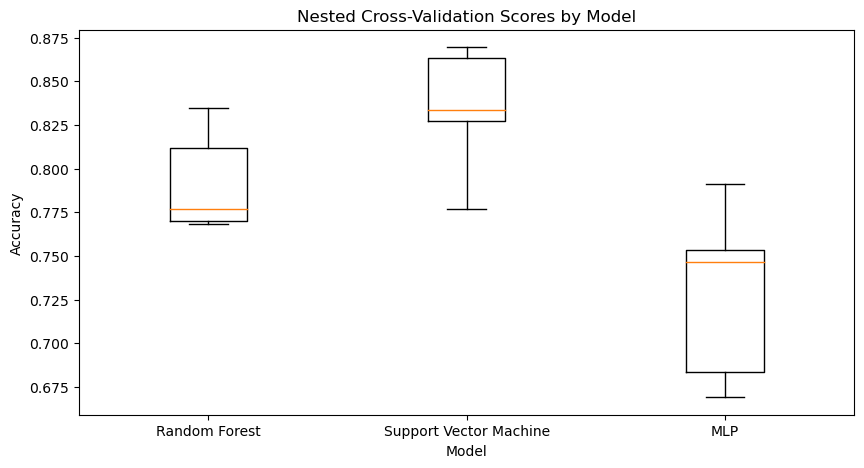

In [19]:
# Plot results
plt.figure(figsize=(10, 5))
plt.boxplot([scores for _, scores in results], labels=[name for name, _ in results])
plt.title('Nested Cross-Validation Scores by Model')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.show()

In [21]:
# Evaluate the best model on a holdout test set (if available)
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    metrics = {
        'Train': {
            'Accuracy': accuracy_score(y_train, y_pred_train),
            'Precision': precision_score(y_train, y_pred_train, average='weighted'),
            'Recall': recall_score(y_train, y_pred_train, average='weighted'),
            'F1 Score': f1_score(y_train, y_pred_train, average='weighted')
        },
        'Test': {
            'Accuracy': accuracy_score(y_test, y_pred_test),
            'Precision': precision_score(y_test, y_pred_test, average='weighted'),
            'Recall': recall_score(y_test, y_pred_test, average='weighted'),
            'F1 Score': f1_score(y_test, y_pred_test, average='weighted')
        }
    }
    return metrics


In [23]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(features_scaled, labels_encoded, test_size=0.2, random_state=42)

In [25]:
# Select the best model based on cross-validation
best_model_name = results_df.loc[results_df['Mean Accuracy'].idxmax(), 'Model']
best_model = models[best_model_name]
pipeline = Pipeline([('scaler', StandardScaler()), ('model', best_model)])
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grids[best_model_name], cv=inner_cv, scoring='accuracy')
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
best_model.set_params(**{k.split('__')[1]: v for k, v in best_params.items()})


SVC(C=10, probability=True)

In [27]:
# Evaluate the best model
metrics = evaluate_model(best_model, X_train, X_test, y_train, y_test)

# Print evaluation metrics
for dataset, metric_values in metrics.items():
    print(f"{dataset} metrics:")
    for metric, value in metric_values.items():
        print(f"  {metric}: {value:.4f}")

Train metrics:
  Accuracy: 0.9440
  Precision: 0.9449
  Recall: 0.9440
  F1 Score: 0.9433
Test metrics:
  Accuracy: 0.8489
  Precision: 0.8553
  Recall: 0.8489
  F1 Score: 0.8474


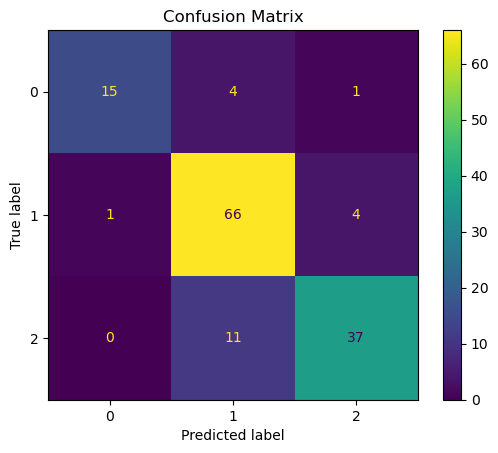

In [29]:
# Confusion Matrix
ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test)
plt.title('Confusion Matrix')
plt.show()

In [31]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from itertools import cycle


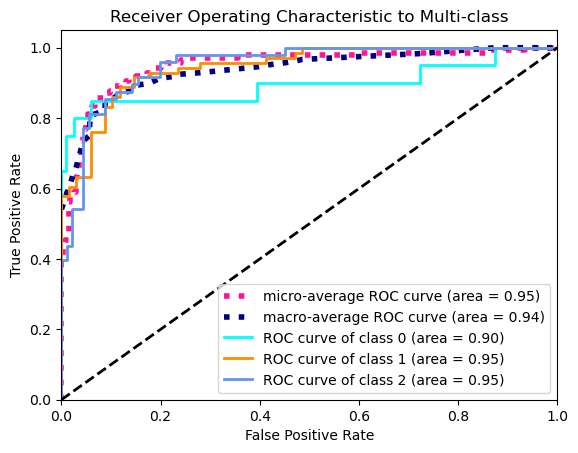

In [33]:
# Binarize the output
y_test_binarized = label_binarize(y_test, classes=np.arange(len(label_encoder.classes_)))
n_classes = y_test_binarized.shape[1]

# Learn to predict each class against the other
y_score = best_model.predict_proba(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binarized.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic to Multi-class')
plt.legend(loc="lower right")
plt.show()

In [43]:
# Check Labels
class_labels = label_encoder.classes_
print(class_labels)


['aggression' 'contact' 'play']
